In [ ]:
# 2020, 22년도 데이터의 전처리

# 패키지 import
import pandas as pd
import numpy as np
import tensorflow as tf

# 데이터 visualize package
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns


# 정규화를 위한 package
from sklearn.preprocessing import MinMaxScaler


# 모델 생성을 위한 package
from tensorflow.keras.layers import LSTM, Dense, Dropout


# 평가지표 package
from tensorflow import metrics
from sklearn.metrics import mean_squared_error


# 하이퍼파라미터 튜닝 package
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential

# 특정 feature에 가중치 부여
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

In [ ]:
"""초기 환경 설정"""
from google.colab import drive

!apt-get update -qq
!apt-get install fonts-nanum* -qq
!fc-cache -fv

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname = font_path)

# 데이터 업로드 환경 설정
drive.mount('/content/drive')

# 정형화된 데이터 프레임으로 확인
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.unicode.east_asian_width', True)

Selecting previously unselected package fonts-nanum.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 di

In [ ]:
"""함수 정의 구간"""


### 데이터 업로드 함수
def upload_data(file_name):
  rtn = pd.read_csv(file_name, encoding = 'euc-kr')
  rtn = pd.DataFrame(rtn)

  return rtn


### data_weather 전처리 함수
def weather_prep(data):
  # 불필요한 열 제거
  drop_columns = ['지점명', '해면기압(hPa)', '운형(운형약어)', '지면상태(지면상태코드)', '강수량(mm)', '5cm 지중온도(°C)', '10cm 지중온도(°C)',
                  '20cm 지중온도(°C)', '30cm 지중온도(°C)']  # 수치화된 정보만을 놓고 비교하기 위해 코드열은 제거함
  data = data.drop(drop_columns, axis=1)

  # column name '일시' -> '시간'
  data = data.rename(columns={'일시': '시간'})

  # '시간' column은 date datatype으로 전환
  data['시간'] = pd.to_datetime(data['시간'])

  return data


### 홍수통제소 데이터 전처리 함수
def river_prep(data):
  # 강수량 데이터 시간에 따라 정렬
  data = data.sort_values(by = '시간', ascending = True)

  # '시간' column의 datatype을 datetime으로 전환
  data['시간'] = pd.to_datetime(data['시간'])

  return data


### 데이터 병합 함수
def merge_data(data_weather, data_rainfall):
  # 데이터 병합
  data = pd.merge(data_rainfall, data_weather, on = '시간')
  data = pd.DataFrame(data)

  return data


### 데이터 visualize 함수
def data_visualize(data):
# 시간별 강수량 데이터
  plt.plot(data['시간'], data['강수량'])
  plt.xlabel('time')
  plt.ylabel('rainfall')
  plt.title('Rainfall / Time')
  plt.show()

  # 시간별 누적 강수량 데이터
  plt.plot(data['시간'], data['누적강수량'])
  plt.xlabel('time')
  plt.ylabel('cumulative rainfall')
  plt.title('Cumulative rainfall / Time')
  plt.show()

  # 시간별 각 인자의 데이터
  for column in data.columns:
      plt.figure()
      plt.plot(data.index, data[column])
      plt.xlabel('Time')
      plt.ylabel(column)
      plt.show()

  return


### 데이터 정규화
# Min-Max Scaling
# 강수량 데이터는 특정 기간에만 발생하고, 그 격차를 유지해야 하기 때문에 Min-Max Scaling으로 진행하였음
def scaling(data):
  # 필요한 데이터만 뽑아옴
  rtn = data[['시간', '강수량', '기온(°C)', '풍속(m/s)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)', '지면온도(°C)', '전운량(10분위)', '중하층운량(10분위)'
  ]]

  # 시간 데이터를 제외한 열만 선택
  scale_col = rtn.columns.difference(['시간'])

  # 데이터 정규화
  scaler = MinMaxScaler()
  rtn[scale_col] = scaler.fit_transform(rtn[scale_col])

  return rtn


### 하천 수위 데이터 레이블링
def target_labeling(data):
  # rtn = [시간, 수위]
  rtn = data[['시간', '수위(m)']].sort_values(by = '시간', ascending = True)

  # 수위 1.5m 미만인 경우는 홍수가 일어났다고 판단하지 않음.
  is_flood = rtn['수위(m)'].apply(lambda x: 0 if x < 1.5 else 1)

  # res_data에 is_flood series 합침
  rtn = rtn.assign(target = is_flood)

  return rtn


### 결측치 처리 함수
def mv_prep(data):
  scale_col = data.columns.difference(['시간', 'target'])

  for col in scale_col:
    data[col] = data[col].interpolate(method = 'linear')

  return data



### 데이터 reshape
# x_data = 입력 변수, y_data = 목표변수, history = 과거 데이터 길이, future = 미래 예측 시점, single_step = 시점 관측 여부
def multivariate_data(x_data, y_data, start, end, history, future, step, single_step):
    x = []
    y = []

    start = start + history
    if end is None:
      end = len(x_data) - future


    for i in range(start, end):
      idx = range(i - history, i, step)
      x.append(x_data[idx])

      if single_step:
        y.append(y_data[i + future])
      else:
        y.append(y_data[i: i + future])

    return np.array(x), np.array(y)


### 수위 데이터 평가
def waterLevplt(data1, data2):
  time = range(len(data2))

  plt.plot(time, data1, label = '실제 수위')
  plt.plot(time, data2, label = '예측 수위')
  plt.xlabel('시간', fontproperties = font_prop)
  plt.ylabel('수위', fontproperties = font_prop)
  plt.legend(prop = font_prop)
  plt.show()


### model 생성 함수
def create_model(units, dropout_rate):
  # 모델 구성
  model = Sequential()
  model.add(LSTM(units = units, input_shape = (history, feature_size)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(6, activation = 'relu'))
  model.add(Dense(1, activation = 'relu'))
  model.compile(loss = 'mse', optimizer = 'adam')

  return model

In [ ]:
# 기상요인 자료 업로드
weather12 = upload_data('/content/drive/MyDrive/Colab Notebooks/12/weather.csv')
weather17 = upload_data('/content/drive/MyDrive/Colab Notebooks/17/weather.csv')
weather20 = upload_data('/content/drive/MyDrive/Colab Notebooks/20/weather.csv')
weather22 = upload_data('/content/drive/MyDrive/Colab Notebooks/22/weather.csv')

weather12 = weather_prep(weather12)
weather17 = weather_prep(weather17)
weather22 = weather_prep(weather22)
weather20 = weather_prep(weather20)

# 강수량 자료 업로드
rainfall12 = upload_data('/content/drive/MyDrive/Colab Notebooks/12/rainfall.csv')
rainfall17 = upload_data('/content/drive/MyDrive/Colab Notebooks/17/rainfall.csv')
rainfall20 = upload_data('/content/drive/MyDrive/Colab Notebooks/20/rainfall.csv')
rainfall22 = upload_data('/content/drive/MyDrive/Colab Notebooks/22/rainfall.csv')


rainfall12 = river_prep(rainfall12)
rainfall17 = river_prep(rainfall17)
rainfall20 = river_prep(rainfall20)
rainfall22 = river_prep(rainfall22)

In [ ]:
# rainfall_weather 데이터 병합
year12_data = merge_data(weather12, rainfall12)
year17_data = merge_data(weather17, rainfall17)
year20_data = merge_data(weather20, rainfall20)
year22_data = merge_data(weather22, rainfall22)

print("12년도 데이터 ======================================\n")
print()
print(year12_data)
print("17년도 데이터 ======================================\n")
print()
print(year17_data)
print("20년도 데이터 ======================================\n")
print(year20_data)
print()
print("22년도 데이터 ======================================\n")
print(year22_data)

12년도 데이터 ======================================


                    시간  강수량  누적강수량  지점  기온(°C)  풍속(m/s)  풍향(16방위)  습도(%)  증기압(hPa)  이슬점온도(°C)  현지기압(hPa)  일조(hr)  일사(MJ/m2)  전운량(10분위)  중하층운량(10분위)  최저운고(100m )  시정(10m)  지면온도(°C)
0    2012-07-01 00:00:00       0           0   119      20.5        1.5           180       96         23.1            19.8         1000.3       NaN          NaN            10.0                 8.0              9.0      500.0          21.6
1    2012-07-01 01:00:00       0           0   119      20.5        1.2           180       95         22.8            19.6         1000.6       NaN          NaN             NaN                 NaN              NaN        NaN          21.5
2    2012-07-01 02:00:00       0           0   119      20.5        1.9           250       95         22.8            19.6         1000.7       NaN          NaN             NaN                 NaN              NaN        NaN          21.4
3    2012-07-01 03:00:00       0           0   119

In [ ]:
### 데이터 정규화
# Min-Max Scaling
# 강수량 데이터는 특정 기간에만 발생하고, 그 격차를 유지해야 하기 때문에 Min-Max Scaling으로 진행하였음
year12_data = scaling(year12_data)
year17_data = scaling(year17_data)
year20_data = scaling(year20_data)
year22_data = scaling(year22_data)


print(year12_data)
print(year17_data)
print(year20_data)
print(year22_data)

                    시간    강수량  기온(°C)  풍속(m/s)   습도(%)  증기압(hPa)  이슬점온도(°C)  지면온도(°C)  전운량(10분위)  중하층운량(10분위)
0    2012-07-01 00:00:00  0.000000  0.122340   0.116279  0.933333     0.360759        0.428571      0.092308             1.0                 0.8
1    2012-07-01 01:00:00  0.000000  0.122340   0.093023  0.916667     0.341772        0.409524      0.089231             NaN                 NaN
2    2012-07-01 02:00:00  0.000000  0.122340   0.147287  0.916667     0.341772        0.409524      0.086154             NaN                 NaN
3    2012-07-01 03:00:00  0.000000  0.117021   0.100775  0.916667     0.335443        0.400000      0.083077             1.0                 1.0
4    2012-07-01 04:00:00  0.000000  0.106383   0.124031  0.933333     0.335443        0.400000      0.083077             1.0                 1.0
...                  ...       ...       ...        ...       ...          ...             ...           ...             ...                 ...
1483 2012-08-31 19:0

<ipython-input-10-c2031376546d>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtn[scale_col] = scaler.fit_transform(rtn[scale_col])
<ipython-input-10-c2031376546d>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rtn[scale_col] = scaler.fit_transform(rtn[scale_col])
<ipython-input-10-c2031376546d>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [ ]:
# 하천 수위 데이터 업로드
target12 = upload_data('/content/drive/MyDrive/Colab Notebooks/12/waterLev.csv')
target17 = upload_data('/content/drive/MyDrive/Colab Notebooks/17/waterLev.csv')
target20 = upload_data('/content/drive/MyDrive/Colab Notebooks/20/waterLev.csv')
target22 = upload_data('/content/drive/MyDrive/Colab Notebooks/22/watherLev.csv')

# 시간에 따라 정렬. 초기 data가 시간 역순으로 정렬되어있어서 재정렬함.
target12 = river_prep(target12)
target17 = river_prep(target17)
target20 = river_prep(target20)
target22 = river_prep(target22)


data12 = merge_data(year12_data, target12[['시간', '수위(m)']])  # 12년도의 데이터
data17 = merge_data(year17_data, target17[['시간', '수위(m)']])  # 17년도의 데이터
data20 = merge_data(year20_data, target20[['시간', '수위(m)']])  # 20년도의 데이터
data22 = merge_data(year22_data, target22[['시간', '수위(m)']]) # 22년도의 데이터

### 결측치 제거
data12 = mv_prep(data12)
data17 = mv_prep(data17)
data20 = mv_prep(data20)
data22 = mv_prep(data22)

print(data12)
print(data17)
print(data20)
print(data22)
# 하천 최고 수위 출력
print("2012 하천 최고 수위 = ", max(target12['수위(m)']))
print("2017 하천 최고 수위 = ", max(target17['수위(m)']))
print("2020 하천 최고 수위 = ", max(target20['수위(m)']))
print("2022 하천 최고 수위 = ", max(target22['수위(m)']))

                    시간  수위(m)    강수량  기온(°C)  풍속(m/s)   습도(%)  증기압(hPa)  이슬점온도(°C)  지면온도(°C)  전운량(10분위)  중하층운량(10분위)
0    2012-07-01 00:00:00     0.12  0.000000  0.122340   0.116279  0.933333     0.360759        0.428571      0.092308             1.0            0.800000
1    2012-07-01 01:00:00     0.11  0.000000  0.122340   0.093023  0.916667     0.341772        0.409524      0.089231             1.0            0.866667
2    2012-07-01 02:00:00     0.10  0.000000  0.122340   0.147287  0.916667     0.341772        0.409524      0.086154             1.0            0.933333
3    2012-07-01 03:00:00     0.09  0.000000  0.117021   0.100775  0.916667     0.335443        0.400000      0.083077             1.0            1.000000
4    2012-07-01 04:00:00     0.08  0.000000  0.106383   0.124031  0.933333     0.335443        0.400000      0.083077             1.0            1.000000
...                  ...      ...       ...       ...        ...       ...          ...             ...          

(1488, 4)


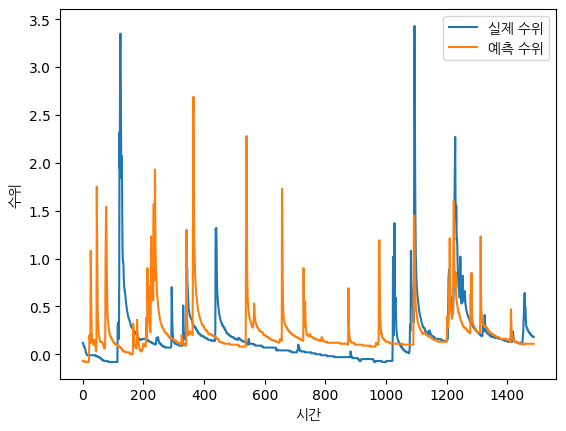

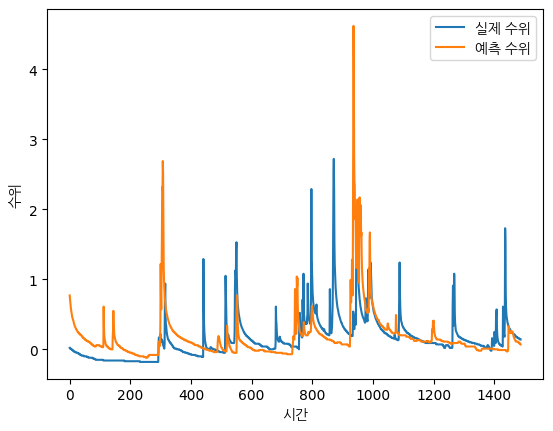

In [ ]:
# 24시간의 데이터로 3시간 이후의 홍수여부 예측
history = 24
future = 4
feature_size = 4


# set1 = x12 = data12['강수량', '기온(°C)'].values
# set2 = x12 = data12[['강수량', '기온(°C)', '이슬점온도(°C)', '습도(%)', '전운량(10분위)']].values
# set3 = x12 = data12[['강수량', '기온(°C)', '습도(%)', '전운량(10분위)']]
# set4 = x12 = data12.drop(['시간', '수위(m)'], axis=1).values

# 12년도 데이터 x, y
x12 = data12[['강수량', '기온(°C)', '습도(%)', '전운량(10분위)']].values
y12 = data12['수위(m)'].values

# 17년도 데이터 x, y
x17 = data17[['강수량', '기온(°C)', '습도(%)', '전운량(10분위)']].values
y17 = data17['수위(m)'].values

# 20년도 데이터 x, y
x20 = data20[['강수량', '기온(°C)', '습도(%)', '전운량(10분위)']].values
y20 = data20['수위(m)'].values

# 학습률 테스트를 위해 feature를 2개로 줄임
x22 = data22[['강수량', '기온(°C)', '습도(%)', '전운량(10분위)']].values
y22 = data22['수위(m)'].values



print(x12.shape)
waterLevplt(y12, y17)
waterLevplt(y20, y22)

In [ ]:
# 12년도 데이터 reshape
x12, y12 = multivariate_data(x12, y12, 0, len(x12) - future, history, future, 1, True)
print("12년도 데이터 shape : ", x12.shape, y12.shape)

# 17년도 데이터 reshape
x17, y17 = multivariate_data(x17, y17, 0, len(x17) - future, history, future, 1, True)
print("17년도 데이터 shape : ", x17.shape, y17.shape)

# 20년도 데이터 reshape
x20, y20 = multivariate_data(x20, y20, 0, len(x20) - future, history, future, 1, True)
print("20년도 데이터 shape : ", x20.shape, y20.shape)

# 데이터 reshape
x22, y22 = multivariate_data(x22, y22, 0, len(x22) - future, history, future, 1, True)
print("22년도 데이터 shape : ", x22.shape, y22.shape)

12년도 데이터 shape :  (1460, 24, 4) (1460,)
17년도 데이터 shape :  (1460, 24, 4) (1460,)
20년도 데이터 shape :  (1460, 24, 4) (1460,)
22년도 데이터 shape :  (1460, 24, 4) (1460,)


In [ ]:
### 모델 생성
model = KerasRegressor(build_fn = create_model, epochs=None, batch_size=32, verbose = 0)

# 하이퍼 파라미터 그리드
params_grid = {
    'units' : [32, 64, 128],
    'dropout_rate' : [0.2, 0.3, 0.4],
    'epochs' : [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid = params_grid, cv = 3)

<ipython-input-25-6faaeb6b7731>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn = create_model, epochs=None, batch_size=32, verbose = 0)


In [ ]:
grid_result = grid.fit(x20, y20)

# 20년도 데이터의 하이퍼 파라미터 튜닝 결과
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.070088 using {'dropout_rate': 0.3, 'epochs': 10, 'units': 128}


In [ ]:
### 최적 하이퍼 파라미터로 모델 생성
# units = 128, dropout_rate = 0.3

# 12년도의 모델 생성
print(x12.shape)
model12 = create_model(128, 0.3)
model12.fit(x12, y12, epochs = 50, batch_size = 32)

# 17년도의 모델 생성
model17 = create_model(128, 0.3)
model17.fit(x17, y17, epochs = 50, batch_size = 32)

# 20년도의 모델 생성
model20 = create_model(128, 0.3)
model20.fit(x20, y20, epochs = 50, batch_size = 32)

# 22년도의 모델 생성
model22 = create_model(128, 0.3)
model22.fit(x22, y22, epochs = 50, batch_size = 32)

(1460, 24, 4)
Epoch 1/50
46/46 [==============================] - 4s 31ms/step - loss: 0.0955
Epoch 2/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0862
Epoch 3/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0783
Epoch 4/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0756
Epoch 5/50
46/46 [==============================] - 1s 32ms/step - loss: 0.0757
Epoch 6/50
46/46 [==============================] - 2s 39ms/step - loss: 0.0721
Epoch 7/50
46/46 [==============================] - 3s 57ms/step - loss: 0.0677
Epoch 8/50
46/46 [==============================] - 2s 40ms/step - loss: 0.0666
Epoch 9/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0677
Epoch 10/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0655
Epoch 11/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0683
Epoch 12/50
46/46 [==============================] - 1s 31ms/step - loss: 0.0638
Epoch 13/50
46/46 [====

46/46 [==============================] - 1s 20ms/step
MSE :  0.06612902017561634


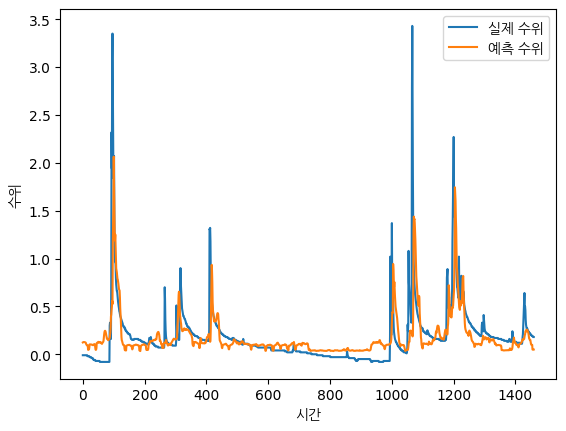

In [ ]:
# 17, 20, 22 년도의 모델로 12년도 데이터 예측
prediction20 = model20.predict(x12)
prediction17 = model17.predict(x12)
prediction22 = model22.predict(x12)


result = (prediction20 + prediction17 + prediction22*2) / 3
mse = mean_squared_error(y12, result)

print("MSE : ", mse)
waterLevplt(y12, result)

46/46 [==============================] - 0s 10ms/step
MSE :  0.05456937637600543


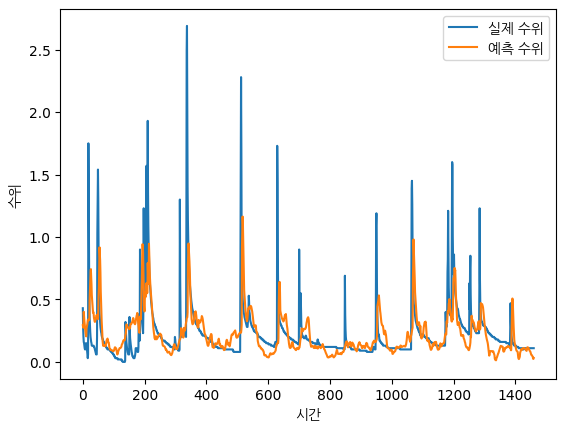

In [ ]:
# 12, 20, 22 년도의 모델로 17년도 데이터 예측
prediction12 = model12.predict(x17)
prediction20 = model20.predict(x17)
prediction22 = model22.predict(x17)


result = (prediction12 + prediction20 + prediction22) / 3
mse = mean_squared_error(y17, result)

print("MSE : ", mse)
waterLevplt(y17, result)

46/46 [==============================] - 1s 19ms/step
MSE :  0.06906023895301538


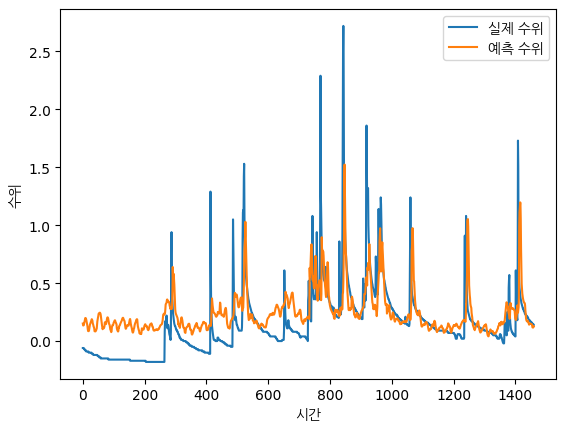

In [ ]:
# 12, 17, 22 년도의 모델로 20년도 데이터 예측
prediction12 = model12.predict(x20)
prediction17 = model17.predict(x20)
prediction22 = model22.predict(x20)


result = (prediction12 + prediction17 + prediction22) / 3

mse = mean_squared_error(y20, result)

print("MSE : ", mse)
waterLevplt(y20, result)

46/46 [==============================] - 1s 11ms/step
MSE :  0.09164338608550403


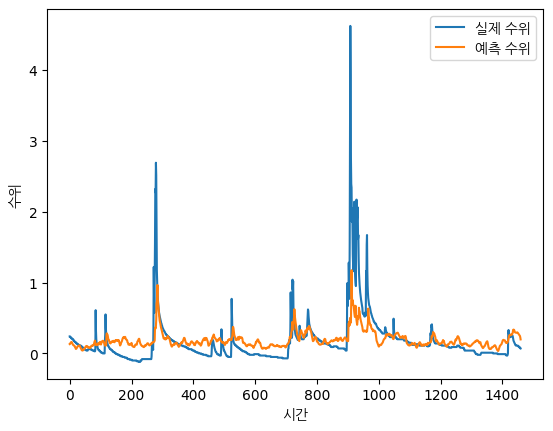

In [ ]:
# 12, 17, 20 년도의 모델로 22년도 데이터 예측
prediction20 = model20.predict(x22)
prediction17 = model17.predict(x22)
prediction12 = model12.predict(x22)


result = (prediction20 + prediction17 + prediction12) / 3
mse = mean_squared_error(y22, result)

print("MSE : ", mse)
waterLevplt(y22, result)